In [1]:
%config IPCompleter.greedy=True

In [2]:
from requests import get
from bs4 import BeautifulSoup
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

In [3]:
url = 'https://www.minsal.cl/nuevo-coronavirus-2019-ncov/casos-confirmados-en-chile-covid-19/'
response = get(url)

In [4]:
html_soup = BeautifulSoup(response.text, 'html.parser')
type(html_soup)

bs4.BeautifulSoup

In [5]:
regiones = [] # [[región1, sexo1, edad1, centro_salud1] ....]
filas = [] # Se guarda cada una de las tuplas sin parsear aún

In [6]:
#Se obtienen las tuplas de la tabla
for table in html_soup.find_all('table'):
    for tr in table.find_all('tr'):
        filas.append(tr)
    break

In [7]:
#Se parsean y se obtienen los datos
region = ''
centro = ''
for i in range(2, len(filas)-1):
    temp = []
    for td in filas[i].find_all('td'):
        temp.append(td)
    if len(temp) == 5:
        #print(patron.findall(temp[1].text))
        region = temp[0].text.strip()
        regiones.append([temp[0].text.strip(), temp[2].text.strip(), temp[3].text.strip(), temp[4].text.strip()])
        #casos_confirmados.append(temp[1].text)
        #sexo.append(temp[2].text)
        #edad.append(temp[3].text)
        #centro_salud.append(temp[4].text)
    elif len(temp) == 3:
        centro = temp[2].text.strip()
        regiones.append([region, temp[0].text.strip(), temp[1].text.strip(), temp[2].text.strip()])
    else:
        regiones.append([region, temp[0].text.strip(), temp[1].text.strip(), centro])
        

In [8]:
#Se normalizan los datos
#patron = re.compile(r'\d+')
femenino = re.compile(r'\bFeme(m|M)ino\b')
for i in range(0,4):
    for x in regiones:
        if x[i] == '—':
            x[i] = np.nan
        elif i == 1:
            x[i] = femenino.sub("Femenino", x[i])
        elif i == 3:
            x[i] = x[i].replace('\n',' ')

In [9]:
#Se setea los encabezados de cada columna del DataFrame
df = pd.DataFrame(regiones, columns=['Región', 'Sexo', 'Edad', 'Centro_salud'])

In [10]:
#Se eliminan las tuplas que contienen NaN
df = df.dropna()

In [11]:
#Se transforma el formato de la columna Edad, de String a Entero
df['Edad'] = df['Edad'].astype(str).astype(int)

In [12]:
#Tabla final con todos los datos de contagios
df

,Región,Sexo,Edad,Centro_salud
6,Metropolitana,Femenino,54,Clínica Alemana
7,Metropolitana,Femenino,40,Clínica Santa María
8,Metropolitana,Masculino,58,Clínica Alemana
9,Metropolitana,Masculino,17,Clínica Alemana
10,Metropolitana,Femenino,83,Clínica Las Condes
11,Metropolitana,Masculino,14,Clínica Alemana
12,Metropolitana,Masculino,42,Clínica U. de Los Andes
13,Metropolitana,Masculino,40,Clínica U. de Los Andes
14,Metropolitana,Femenino,31,Clínica Santa María
15,Metropolitana,Femenino,32,Clínica Alemana


In [13]:
df1 = df.groupby('Región')['Región'].count().reset_index(name='Cantidad')

In [14]:
df1

,Región,Cantidad
0,Biobío,1
1,Los Lagos,1
2,Maule,7
3,Metropolitana,23
4,Ñuble,1


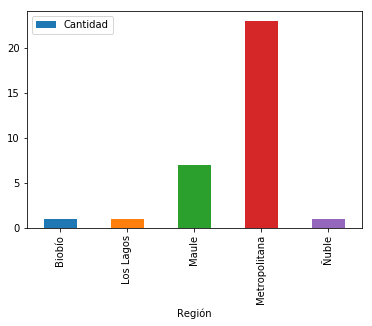

In [15]:
df1.plot(kind='bar',x='Región',y='Cantidad')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000B7E01A3F60>]],
      dtype=object)

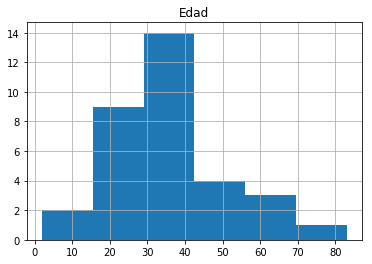

In [16]:
df.hist(bins=6)

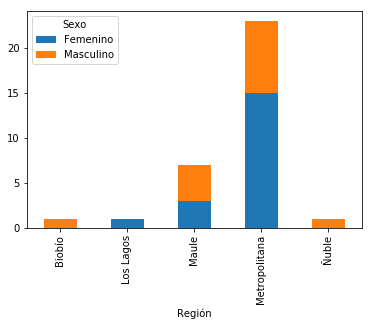

In [17]:
df.groupby(['Región','Sexo']).size().unstack().plot(kind='bar',stacked=True)
plt.show()

In [18]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="Covid19-CL")
location = geolocator.geocode("Región Metropolitana, Chile")
print(location.address)
#Flatiron Building, 175, 5th Avenue, Flatiron, New York, NYC, New York, ...
print((location.latitude, location.longitude))
#(40.7410861, -73.9896297241625)
#print(location.raw)
#{'place_id': '9167009604', 'type': 'attraction', ...}

San Pablo 2966 5to Piso, Santiago, Región Metropolitana, Chile, 2966, Avenida San Pablo, Quinta Normal, Provincia de Santiago, Región Metropolitana de Santiago, 8350485, Chile
(-33.4354421, -70.6766162)


In [19]:
from geopy.extra.rate_limiter import RateLimiter

df_loc = df
df_loc['Address'] = 'Región ' + df_loc['Región'] + ', Chile'
lat = []
lon = []
for index, row in df_loc.iterrows():
    location = geolocator.geocode(row['Address'])
    lat.append(location.latitude)
    lon.append(location.longitude)
df_loc['lat'] = lat
df_loc['lon'] = lon
df_loc


,Región,Sexo,Edad,Centro_salud,Address,lat,lon
6,Metropolitana,Femenino,54,Clínica Alemana,"Región Metropolitana, Chile",-33.435442,-70.676616
7,Metropolitana,Femenino,40,Clínica Santa María,"Región Metropolitana, Chile",-33.435442,-70.676616
8,Metropolitana,Masculino,58,Clínica Alemana,"Región Metropolitana, Chile",-33.435442,-70.676616
9,Metropolitana,Masculino,17,Clínica Alemana,"Región Metropolitana, Chile",-33.435442,-70.676616
10,Metropolitana,Femenino,83,Clínica Las Condes,"Región Metropolitana, Chile",-33.435442,-70.676616
11,Metropolitana,Masculino,14,Clínica Alemana,"Región Metropolitana, Chile",-33.435442,-70.676616
12,Metropolitana,Masculino,42,Clínica U. de Los Andes,"Región Metropolitana, Chile",-33.435442,-70.676616
13,Metropolitana,Masculino,40,Clínica U. de Los Andes,"Región Metropolitana, Chile",-33.435442,-70.676616
14,Metropolitana,Femenino,31,Clínica Santa María,"Región Metropolitana, Chile",-33.435442,-70.676616
15,Metropolitana,Femenino,32,Clínica Alemana,"Región Metropolitana, Chile",-33.435442,-70.676616


In [59]:
import folium
from folium.plugins import MarkerCluster

map1 = folium.Map(
    location=[-35.675148,-71.5429688],
    tiles='OpenStreetMap',
    zoom_start=4.5,
)
mc = MarkerCluster()

for row in df_loc.itertuples():
    mc.add_child(folium.Marker(location=[row.lat, row.lon], popup=folium.Popup('Edad: ' + str(row.Edad) + ' ' + row.Sexo + '  (' + row.Centro_salud + ')', max_width=90)))
mc.add_to(map1)
map1
#folium.CircleMarker(location= [location.latitude, location.longitude]).add_to(map1)
#df.apply(lambda row:folium.CircleMarker(location=[row["latitude"], row["longitude"]]).add_to(map1), axis=1)
#df_loc.apply(lambda row:folium.Marker(location=[row['lat'], row['lon']], popup = row['Edad']).add_to(map1), axis=1)
#map1